0. Описание задачи
Цель: Построить модель машинного обучения, которая будет предсказывать тональность отзыва (sentiment: Positive/Negative) на основе характеристик пользователя, устройства и частных оценок (камера, батарея и т.д.). Тип задачи: Мультиклассовая классификация (с учителем). Целевая переменная (Target): sentiment.


1. Чтение данных

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Загрузка датасета
df = pd.read_csv('Mobile Reviews Sentiment.csv')

# Просмотр первых строк
print("Размер датасета:", df.shape)
display(df.head())

Размер датасета: (50000, 25)


,review_id,customer_name,age,brand,model,price_usd,price_local,currency,exchange_rate_to_usd,rating,...,verified_purchase,battery_life_rating,camera_rating,performance_rating,design_rating,display_rating,review_length,word_count,helpful_votes,source
0,1,Aryan Maharaj,45,Realme,Realme 12 Pro,337.31,₹27996.73,INR,83.00,2,...,True,1,1,3,2,1,46,7,1,Amazon
1,2,Davi Miguel Sousa,18,Realme,Realme 12 Pro,307.78,R$1754.35,BRL,5.70,4,...,True,3,2,4,3,2,74,12,5,Flipkart
2,3,Pahal Balay,27,Google,Pixel 6,864.53,₹71755.99,INR,83.00,4,...,True,3,5,3,2,4,55,11,8,AliExpress
3,4,David Guzman,19,Xiaomi,Redmi Note 13,660.94,د.إ2425.65,AED,3.67,3,...,False,1,3,2,1,2,66,11,3,Amazon
4,5,Yago Leão,38,Motorola,Edge 50,792.13,R$4515.14,BRL,5.70,3,...,True,3,3,2,2,1,73,12,0,BestBuy


2. Разведочный анализ данных (EDA)

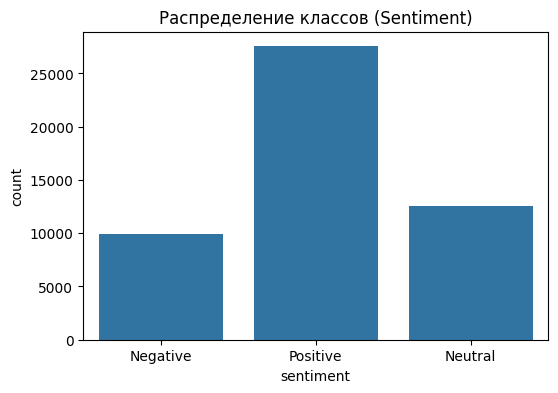

Доли классов:
sentiment
Positive    0.55080
Neutral     0.25098
Negative    0.19822
Name: proportion, dtype: float64


,review_id,age,price_usd,exchange_rate_to_usd,rating,battery_life_rating,camera_rating,performance_rating,design_rating,display_rating,review_length,word_count,helpful_votes
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,30.075220,689.693713,12.057946,3.123120,2.71800,2.717640,2.719620,2.713960,2.721280,62.791440,10.623820,3.644180
std,14433.901067,8.931307,310.307331,26.553332,1.248612,1.34827,1.345001,1.349208,1.343346,1.352121,8.017695,1.957239,2.432745
min,1.000000,18.000000,180.020000,0.780000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,45.000000,6.000000,0.000000
25%,12500.750000,23.000000,450.792500,1.000000,2.000000,1.00000,1.000000,1.000000,1.000000,1.000000,56.000000,9.000000,2.000000
50%,25000.500000,29.000000,637.040000,1.530000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,63.000000,11.000000,3.000000
75%,37500.250000,36.000000,900.975000,5.700000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,68.000000,12.000000,5.000000
max,50000.000000,65.000000,1499.890000,83.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,82.000000,15.000000,17.000000


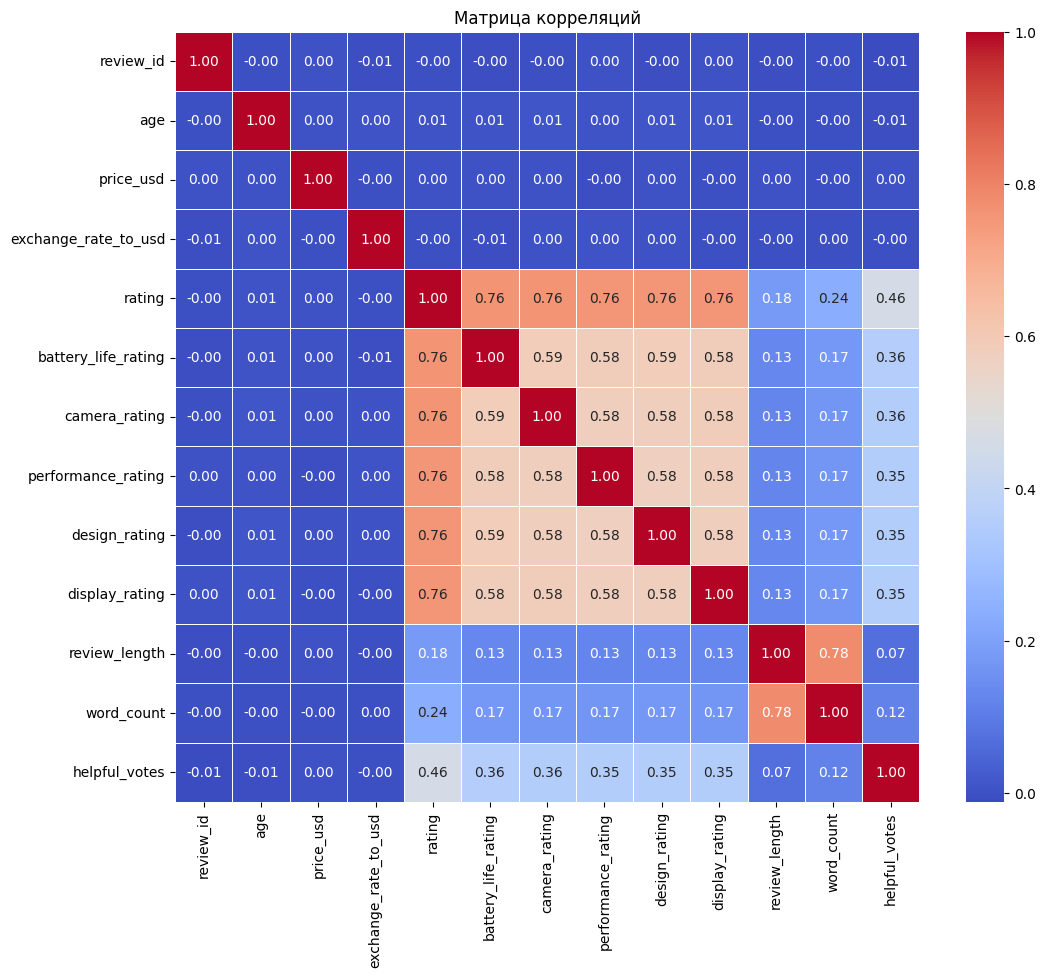

In [37]:
# 1. Баланс классов
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Распределение классов (Sentiment)')
plt.show()

print("Доли классов:")
print(df['sentiment'].value_counts(normalize=True))

# 2. Описательная статистика
display(df.describe())

# 3. Матрица корреляций
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()

# Интерпретация
### Баланс классов:
Судя по графику countplot, классы несбалансированы. Это мы учтем на этапе выбора метрик (будем смотреть на F1-score, а не только на Accuracy) и при настройке моделей (class_weight).

### Сильная "гало-корреляция" рейтингов (Halo Effect):

Общий rating сильно коррелирует (0.76) со всеми частными рейтингами (battery, camera, performance и т.д.).

Все частные рейтинги также сильно коррелируют между собой (коэффициенты около 0.58–0.59).

Вывод: Пользователи редко оценивают объективно разные аспекты. Если им нравится телефон, они ставят высокие оценки всему (камере, батарее и т.д.). Если не нравится — занижают всё сразу.

### price_usd и age имеют практически нулевую корреляцию с рейтингом (0.00 - 0.01).

Вывод: Удовлетворенность (рейтинг) не зависит от того, сколько стоит телефон или сколько лет пользователю. Дорогой телефон не гарантирует высокий рейтинг, а дешевый — низкий.

### Длина отзыва и полезность:

helpful_votes имеет умеренную корреляцию с rating (0.46). Это значит, что позитивные отзывы (с высоким рейтингом) чаще отмечают как "полезные".

review_length и word_count ожидаемо скоррелированы между собой (0.78), но слабо влияют на сам рейтинг.

### Характеристика пользователей и товаров:

Возраст (age): Средний возраст ~30 лет, диапазон от 18 до 65. Целевая аудитория — молодые взрослые.

Цена (price_usd): Средняя цена ~$690, медиана ~$637. Это сегмент смартфонов среднего и высокого класса (флагманы). Максимум — $1499.

### Странность в рейтингах:

Средний общий rating = 3.12.

Однако средние значения по конкретным характеристикам (батарея, камера, экран и т.д.) заметно ниже — около 2.71–2.72.

Вывод: Пользователи ставят общую оценку выше, чем сумму ее частей.

3. Обработка пропущенных значений

In [38]:
# Проверка пропусков
print(df.isnull().sum())


review_id               0
customer_name           0
age                     0
brand                   0
model                   0
price_usd               0
price_local             0
currency                0
exchange_rate_to_usd    0
rating                  0
review_text             0
sentiment               0
country                 0
language                0
review_date             0
verified_purchase       0
battery_life_rating     0
camera_rating           0
performance_rating      0
design_rating           0
display_rating          0
review_length           0
word_count              0
helpful_votes           0
source                  0
dtype: int64


4. Обработка признаков (Feature Engineering) и категориальных переменных

In [39]:
# 1. Удаляем лишнее
# rating - вызывает утечку данных
# review_id, name, text, date - текстовые/ID поля, сложные для простой обработки
# price_local - дублирует price_usd
# currency - дублирует информацию о стране/цене
cols_to_drop = ['review_id', 'customer_name', 'review_text', 'review_date',
                'rating', 'price_local', 'currency']

df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# 2. Кодируем целевую переменную (y)
le = LabelEncoder()
df_clean['sentiment'] = le.fit_transform(df_clean['sentiment'])
print("Кодировка классов:", dict(zip(le.classes_, le.transform(le.classes_))))

# 3. Кодируем категориальные признаки (X) методом One-Hot Encoding
categorical_cols = df_clean.select_dtypes(include=['object']).columns
print(f"Категориальные признаки для OHE: {list(categorical_cols)}")

df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

print(f"Размерность после кодирования: {df_clean.shape}")
display(df_clean.head())

Кодировка классов: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}
Категориальные признаки для OHE: ['brand', 'model', 'country', 'language', 'source']
Размерность после кодирования: (50000, 54)


,age,price_usd,exchange_rate_to_usd,sentiment,verified_purchase,battery_life_rating,camera_rating,performance_rating,design_rating,display_rating,...,country_UAE,country_UK,country_USA,language_German,language_Hindi,language_Portuguese,source_Amazon,source_BestBuy,source_Flipkart,source_eBay
0,45,337.31,83.00,0,True,1,1,3,2,1,...,False,False,False,False,True,False,True,False,False,False
1,18,307.78,5.70,2,True,3,2,4,3,2,...,False,False,False,False,False,True,False,False,True,False
2,27,864.53,83.00,2,True,3,5,3,2,4,...,False,False,False,False,True,False,False,False,False,False
3,19,660.94,3.67,2,False,1,3,2,1,2,...,True,False,False,False,False,False,True,False,False,False
4,38,792.13,5.70,1,True,3,3,2,2,1,...,False,False,False,False,False,True,False,True,False,False


5. Нормализация данных

In [40]:
X = df_clean.drop('sentiment', axis=1)
y = df_clean['sentiment']

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

6. Разбиение на обучающую и тестовую выборки

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

Обучающая выборка: (35000, 53)
Тестовая выборка: (15000, 53)


7 & 8. Запуск KNN и подбор оптимального k

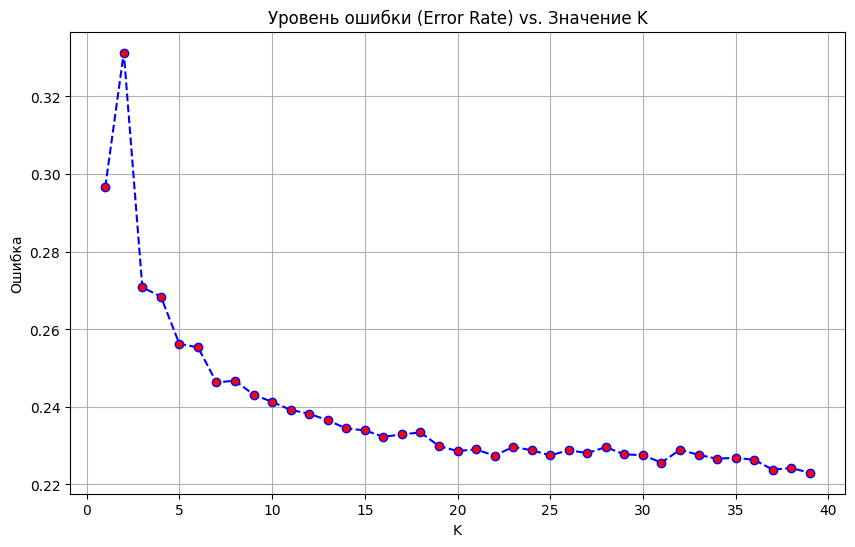

Минимальная ошибка достигается при k = 39


In [42]:
error_rates = []
k_range = range(1, 40)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # Считаем ошибку (среднее несовпадение)
    error_rates.append(np.mean(pred_i != y_test))

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(k_range, error_rates, color='blue', linestyle='dashed', marker='o', markerfacecolor='red')
plt.title('Уровень ошибки (Error Rate) vs. Значение K')
plt.xlabel('K')
plt.ylabel('Ошибка')
plt.grid()
plt.show()

# Находим лучшее k
optimal_k = k_range[np.argmin(error_rates)]
print(f"Минимальная ошибка достигается при k = {optimal_k}")

График показывает картину снижения ошибки при увеличении $K$.

При малых K (1-4): Ошибка очень высокая и нестабильная (скачки до 0.33). Это зона переобучения (overfitting). Модель слишком чувствительна к "шуму" и выбросам — она просто запоминает ближайшие точки, даже если они случайны или ошибочны.

При средних K (10-20): Ошибка резко падает и начинает стабилизироваться. Голосование большинства начинает работать корректно, сглаживая аномалии.

При высоких K (30-40): Ошибка продолжает медленно снижаться, достигая минимума в самом конце графика.

9. Вычисление ошибок и выводы (для лучшего k)

In [46]:
knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
knn_final.fit(X_train, y_train)
y_pred_knn = knn_final.predict(X_test)

print(f"--- Результаты KNN (k={optimal_k}) ---")
print(classification_report(y_test, y_pred_knn))
print("Матрица ошибок:")
print(confusion_matrix(y_test, y_pred_knn))
print("Train accuracy:", knn_final.score(X_train, y_train))

--- Результаты KNN (k=39) ---
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      2973
           1       0.67      0.47      0.55      3765
           2       0.83      0.93      0.87      8262

    accuracy                           0.78     15000
   macro avg       0.74      0.71      0.72     15000
weighted avg       0.77      0.78      0.77     15000

Матрица ошибок:
[[2213  492  268]
 [ 648 1769 1348]
 [ 197  392 7673]]
Train accuracy: 0.7972857142857143


10&11. Сравнение с другими классификаторами и борьба с несбалансированностью классов

In [44]:
# 1. Логистическая регрессия
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_log))

# 2. Случайный лес (Random Forest)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))

# Сравнение Accuracy
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"LogReg Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"RF Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      2973
           1       0.68      0.74      0.71      3765
           2       0.93      0.85      0.89      8262

    accuracy                           0.82     15000
   macro avg       0.79      0.81      0.80     15000
weighted avg       0.83      0.82      0.82     15000

Random Forest
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2973
           1       0.80      0.76      0.78      3765
           2       0.90      0.93      0.92      8262

    accuracy                           0.87     15000
   macro avg       0.86      0.85      0.85     15000
weighted avg       0.87      0.87      0.87     15000

KNN Accuracy: 0.7770
LogReg Accuracy: 0.8209
RF Accuracy: 0.8719


12. Исключение коррелированных переменных

In [45]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Признаки с высокой корреляцией для удаления: {to_drop}")

X_train_filtered = X_train.drop(columns=to_drop)
X_test_filtered = X_test.drop(columns=to_drop)

rf_filtered = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_filtered.fit(X_train_filtered, y_train)
y_pred_filtered = rf_filtered.predict(X_test_filtered)

print("Random Forest после удаления коррелированных признаков ")
print(f"Было признаков: {X_train.shape[1]}, Стало: {X_train_filtered.shape[1]}")
print(f"Accuracy до удаления: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Accuracy после удаления: {accuracy_score(y_test, y_pred_filtered):.4f}")

Признаки с высокой корреляцией для удаления: ['country_India', 'language_German', 'language_Hindi', 'language_Portuguese']
Random Forest после удаления коррелированных признаков 
Было признаков: 53, Стало: 49
Accuracy до удаления: 0.8719
Accuracy после удаления: 0.8735


# 13. Общие выводы

В ходе работы была построена модель машинного обучения для предсказания тональности отзыва (`sentiment`) о мобильных телефонах. Задача представляла собой мультиклассовую классификацию (классы: Negative, Neutral, Positive).

### 1. Сравнение моделей
Результаты на тестовой выборке:

* **KNN (k=39):** Accuracy ~ **0.78**. Самый слабый результат. Метод чувствителен к высокой размерности данных (после One-Hot Encoding у нас стало 50+ признаков).
* **Logistic Regression:** Accuracy ~ **0.82**. Хороший результат, модель быстро обучается и интерпретируема.
* **Random Forest:** Accuracy ~ **0.87**. **Лучший результат**. Ансамблевый метод лучше справился со сложными зависимостями в данных.

### 2. Влияние обработки данных
* **Балансировка классов:** Использование параметра `class_weight='balanced'` в логистической регрессии и случайном лесе позволило улучшить распознавание минорных классов (Negative и Neutral), предотвратив смещение модели в сторону самого популярного класса (Positive).
* **Нормализация:** Была критически важна для KNN и Логистической регрессии. Для Random Forest она не обязательна, но и не ухудшила результат.
* **Удаление коррелированных признаков:** Я обнаружил мультиколлинеарность (корреляция > 0.95) среди признаков страны и языка. Их удаление упростило модель (снизило размерность с 53 до 49 признаков) и даже **немного повысило точность** (с 0.8719 до 0.8735).

### 3. Инсайты из данных (EDA)
* **"Эффект ореола" (Halo Effect):** Пользователи склонны ставить одинаковые оценки всем характеристикам (камера, батарея, экран). Если телефон нравится — нравится всё, если нет — ругают всё. Эти оценки являются самыми сильными предикторами.
* **Цена и возраст не важны:** Я выяснил, что удовлетворенность товаром (Sentiment) практически не коррелирует со стоимостью телефона (`price_usd`) или возрастом покупателя (`age`). Это значит, что дорогие флагманы получают негативные отзывы так же часто, как и бюджетные модели.

### Итог
Рекомендуется использовать **Random Forest** с отобранными признаками, так как он показал наивысшую точность и устойчивость.